<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# **Project 3: NLP Classification - Identifying The Risk of Depression**

>Author: Gilbert, Han Kiong, Wee Zheng

---

### **Context**
Mental health is a growing concern in Singapore, particularly among youths, with depression being the most prevalent mental illness. The increase in depression rates among young people is largely attributed to extensive social media use, where factors like cyberbullying and the pressure to maintain a positive online image are prevalent. Considering the challenges in limiting social media usage among youths, a more viable approach is to leverage social media as a tool to identify and mitigate the rising depression rates, thereby offering better support to those in need.

### **Problem Statement**
Our project is focused on addressing the critical question: **How can we detect if youths are at risk of depression based on their online posts?**. The primary goal is to develop a predictive model that identifies whether a youth is at risk of depression by analyzing their social media activity. 

These are the notebooks for this project:  
 1. [01_Web_Scraping](01_web_scraping.ipynb)
 2. [02_Data_Cleaning](02_data_cleaning.ipynb)
 3. [03_Preprocessing_and_EDA](03_preprocessing_and_eda.ipynb)
 4. [04_Modelling](04_modelling.ipynb) 

 ---

  # This Notebook: 04_Modelling

  ---

#### **Import Libraries**

In [182]:
import pandas as pd 
import nltk

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score


import warnings
warnings.filterwarnings('ignore')

#### **Import Datasets**

In [88]:
df = pd.read_csv('../output/depression_happy_processed_final.csv')

Overview of Datasets

In [89]:
df.head()

,id,author,score,total comment,created_utc,subreddit,title_and_body,tokenize,lemmatized,stemmed
0,doqwow,SQLwitch,2364,177.0,1572360722,depression,our most-broken and least-understood rules is ...,"['broken', 'least', 'understood', 'rules', 'he...","['least', 'rule', 'helpers', 'invite', 'privat...","['broken', 'least', 'understood', 'rule', 'hel..."
1,16kqyd7,SQLwitch,66,395.0,1694923331,depression,"regular check-in post, with information about ...","['regular', 'check', 'post', 'information', 'r...","['regular', 'check', 'information', 'rule', 'w...","['regular', 'check', 'post', 'inform', 'rule',..."
2,1bk9m1a,pan-playdate,176,355.0,1711035875,depression,what's yalls depression food mine is either ma...,"['yalls', 'depression', 'food', 'mine', 'eithe...","['depression', 'food', 'mine', 'mac', 'cheese'...","['yall', 'depress', 'food', 'mine', 'either', ..."
3,1bkonr0,TheChubbyPlant,21,5.0,1711074477,depression,"suicides in the us reached over 50k in 2023, t...","['suicides', 'us', 'reached', 'highest', 'ever...","['suicides', 'reach', 'highest', 'crazy', 'kil...","['suicid', 'us', 'reach', 'highest', 'ever', '..."
4,1bkkksj,Beneficial-Tax-9093,23,29.0,1711062851,depression,antidepressants will make sex impossible i've ...,"['antidepressants', 'make', 'sex', 'impossible...","['antidepressants', 'sex', 'impossible', 'seve...","['antidepress', 'make', 'sex', 'imposs', 'seve..."


Check null values 

In [90]:
df.isnull().sum()

id                    0
author              408
score                 0
total comment     10931
created_utc           0
subreddit             0
title_and_body        0
tokenize              0
lemmatized            0
stemmed               0
dtype: int64

`Author` and `total comment` are not used in creating the prediction model, so the null values in these columns will not be further addressed.

### **Data Dictionary**


|Feature|Type|Dataset|Description|
|---|---|---|---|
|id|*str*|depression_happy_processed|Unique ID for each post|
|author|*str*|depression_happy_processed|Represents the username of the post owner|
|score|*integer*|depression_happy_processed|The post number of posts upvotes minus downvotes|
|total comment|*float*|depression_happy_processed|Total number of comments on the reddit post |
|created_utc|*integer*|depression_happy_processed|The time stamp when the post is created in UNIX time form|
|subteddit|*str*|depression_happy_processed|Name of the subreddit where the post is extracted|
|title_and_body|*str*|depression_happy_processed|Content of the post|
|tokenize|*str*|depression_happy_processed|List of tokenized words from title_and_body|
|lemmatized|*str*|depression_happy_processed|List of lemmatized words|
|stemmed|*str*|depression_happy_processed|List of stemmed words|


### **1. Model Preparation**

---

This part of the notebook consists of 3 parts:
1. Data preprocessing
2. Define input (X) and output (y)
3. Data balancing
4. Train and test data preparation



#### **1.1 Data Preprocessing**

---
We will convert the output (y) to numerical values with the following values: 
- `depression` = 1
- `happy` = 0

In [91]:
#convert subreddit to binary value
df['subreddit'] = df['subreddit'].apply(lambda x: 1 if x == 'depression' else 0)

#### **1.2 Define input (X) and output (y)**

---

X represents the input features or independent variables used to train the model, while y represents the target variable or dependent variable that the model aims to predict.


In [92]:
#define X and y
X = df['lemmatized']
y = df['subreddit']

#### **1.3 Data Balancing**

---

Check proportion of y 

In [93]:
#check proportion
y.value_counts(normalize=True)

subreddit
0    0.648429
1    0.351571
Name: proportion, dtype: float64

Due to the imbalanced classes between `depression` and `happy`, the model could become biased towards the majority class (`happy`). This bias may cause the model to perform poorly in identifying the minority class (`depression`), which we want to avoid. To balance the classes before modeling, we will take a 50% random sample from the `happy` class.

In [94]:
#separate happy and depression to 2 dataframe
df_happy = df[df['subreddit'] == 0].reset_index(drop = True)
df_depression = df[df['subreddit'] == 1].reset_index(drop = True)

In [95]:
#random sample happy datasets
df_sample = df_happy.sample(n = df_happy.shape[0]//2,
                            replace = True,
                            random_state=42)

In [96]:
#concat the dataframe after sampling
df2_aftersample = pd.concat([df_depression,df_sample],axis=0)

In [97]:
#define X and y
X = df2_aftersample['lemmatized']
y = df2_aftersample['subreddit']

Check depression and happy proportion

In [98]:
y.value_counts(normalize=True)

subreddit
1    0.52027
0    0.47973
Name: proportion, dtype: float64

Based on the proportion figures above, the proportion of classes between `happy(0)` and `depression(1)` is now balanced. We will proceed with train test split 

#### **1.4 Train and Test Data Preparation**
---

The purpose of train-test split is to divide the dataset into two separate sets: one for training the model and one for testing its performance. This allows us to evaluate how well the model generalizes to unseen data and helps prevent overfitting.

In [99]:
#create train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

### **2. Baseline Modelling**
---

As a data scientist, we need to create several predictive model and compare which model gives the highest metrics score. For this project, we will compare 6 models and select the best model:

1. Naive Bayes with CounterVectorizer
2. Naive Bayes with TF-IDF
3. Logistic Regression with CounterVectorizer
4. Logistic Regression with TF-IDF
5. kNN with CounterVectorizer
6. kNN with TF-IDF

Before going to modelling, we will identify what metrics is important for our modelling

**Confusion matrix**

|              | Predicted Negative | Predicted Positive |
|--------------|--------------------|--------------------|
| Actual Negative |        TN          |        FP          |
| Actual Positive |        FN          |        TP          |

Interpretation:
- TN = Predicted not at risk of depression, and actual not at risk of depression
- FN = Predicted not at risk of depression, but actual at risk of depression
- TP = Predicted at risk of depression, and actual at risk of depression
- FP = Predicted at risk of depression, but actual not at risk of depression

Looking at the confusion matrix, we want to maximize TP and minimize FN
- Maximize TP: To get as many prediction that someone is at risk of depression as close as possible to actual 
- Minimize FN: To minimize predicting someone is not at risk of depression, but actually at risk of depression. We want to minimize this situation as much as possible because these group people may not receive necessary help due to the prediction error.

Judging from these 2, to maximize TP and minimize FP, our model will be evaluated based on `recall`

In [100]:
#Instantiate countervectorizer 
cvec = CountVectorizer()

In [101]:
#instantiate TF-IDF
tvec = TfidfVectorizer()

In [102]:
#fit and transfrom X_train with Counter Vectorizer
X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train).todense(), columns= cvec.get_feature_names_out())


In [103]:
#fit and transform X_train with TF-IDF
X_train_tvec = pd.DataFrame(tvec.fit_transform(X_train).todense(), columns = tvec.get_feature_names_out())

In [104]:
#transform X_test with Counter Vectorizer
X_test_cvec = pd.DataFrame(cvec.transform(X_test).todense(),columns= cvec.get_feature_names_out())

In [105]:
#transform X_test with Counter Vectorizer
X_test_tvec = pd.DataFrame(tvec.transform(X_test).todense(),columns = tvec.get_feature_names_out())

In [106]:
#instantiate logistic regression
logreg= LogisticRegression()

#instantiate Naive Bayes 
nb = MultinomialNB()

#instantiate kNN
knn = KNeighborsClassifier()

In [107]:
#fit the model
#with countervectorizer
logreg_cvec_model = logreg.fit(X_train_cvec,y_train)
nb_cvec_model = nb.fit(X_train_cvec,y_train)
knn_cvec_model = knn.fit(X_train_cvec,y_train)

#with TF-IDF
logreg_tvec_model = logreg.fit(X_train_tvec,y_train)
nb_tvec_model = nb.fit(X_train_tvec,y_train)
knn_tvec_model = knn.fit(X_train_tvec,y_train)

Accuracy score 

In [108]:
#print and compare score 
print(f"Logistic Regression with CounterVectorizer train score {logreg_cvec_model.score(X_train_cvec,y_train)}")
print(f"Logistic Regression with CounterVectorizer test score {logreg_cvec_model.score(X_test_cvec,y_test)}")
print(f"Logistic Regression with TF-IDF train score {logreg_tvec_model.score(X_train_tvec,y_train)}")
print(f"Logistic Regression with TF-IDF test score {logreg_tvec_model.score(X_test_tvec,y_test)}")
print(f"Naive Bayes with CounterVectorizer train score {nb_cvec_model.score(X_train_cvec,y_train)}")
print(f"Naive Bayes with CounterVectorizer test score {nb_cvec_model.score(X_test_cvec,y_test)}")
print(f"Naive Bayes with TF-IDF train score {nb_tvec_model.score(X_train_tvec,y_train)}")
print(f"Naive Bayes with TF-IDF test score {nb_tvec_model.score(X_test_tvec,y_test)}")
print(f"kNN with CounterVectorizer train score {knn_cvec_model.score(X_train_cvec,y_train)}")
print(f"kNN with CounterVectorizer test score {knn_cvec_model.score(X_test_cvec,y_test)}")
print(f"kNN with TF-IDF train score {knn_tvec_model.score(X_train_tvec,y_train)}")
print(f"kNN with TF-IDF test score {knn_tvec_model.score(X_test_tvec,y_test)}")


Logistic Regression with CounterVectorizer train score 0.8785564540281522
Logistic Regression with CounterVectorizer test score 0.8212842388863942
Logistic Regression with TF-IDF train score 0.9046121593291404
Logistic Regression with TF-IDF test score 0.8383475527615626
Naive Bayes with CounterVectorizer train score 0.838125187181791
Naive Bayes with CounterVectorizer test score 0.7907498877413561
Naive Bayes with TF-IDF train score 0.850104821802935
Naive Bayes with TF-IDF test score 0.797485406376291
kNN with CounterVectorizer train score 0.8379754417490266
kNN with CounterVectorizer test score 0.7687471935339021
kNN with TF-IDF train score 0.5245582509733453
kNN with TF-IDF test score 0.49034575662325997


Sensitivity Score 

In [171]:
#create train confusion matrix
train_tn1_base, train_fp1_base, train_fn1_base, train_tp1_base = confusion_matrix(y_train,logreg_cvec_model.predict(X_train_cvec)).ravel()
train_tn2_base, train_fp2_base, train_fn2_base, train_tp2_base = confusion_matrix(y_train,logreg_tvec_model.predict(X_train_tvec)).ravel()
train_tn3_base, train_fp3_base, train_fn3_base, train_tp3_base = confusion_matrix(y_train,nb_cvec_model.predict(X_train_cvec)).ravel()
train_tn4_base, train_fp4_base, train_fn4_base, train_tp4_base = confusion_matrix(y_train,nb_tvec_model.predict(X_train_tvec)).ravel()
train_tn5_base, train_fp5_base, train_fn5_base, train_tp5_base = confusion_matrix(y_train,knn_cvec_model.predict(X_train_cvec)).ravel()
train_tn6_base, train_fp6_base, train_fn6_base, train_tp6_base = confusion_matrix(y_train,knn_tvec_model.predict(X_train_tvec)).ravel()

In [175]:
#create test confusion matrix 
test_tn1_base, test_fp1_base, test_fn1_base, test_tp1_base = confusion_matrix(y_test,logreg_cvec_model.predict(X_test_cvec)).ravel()
test_tn2_base, test_fp2_base, test_fn2_base, test_tp2_base = confusion_matrix(y_test,logreg_tvec_model.predict(X_test_tvec)).ravel()
test_tn3_base, test_fp3_base, test_fn3_base, test_tp3_base = confusion_matrix(y_test,nb_cvec_model.predict(X_test_cvec)).ravel()
test_tn4_base, test_fp4_base, test_fn4_base, test_tp4_base = confusion_matrix(y_test,nb_tvec_model.predict(X_test_tvec)).ravel()
test_tn5_base, test_fp5_base, test_fn5_base, test_tp5_base = confusion_matrix(y_test,knn_cvec_model.predict(X_test_cvec)).ravel()
test_tn6_base, test_fp6_base, test_fn6_base, test_tp6_base = confusion_matrix(y_test,knn_tvec_model.predict(X_test_tvec)).ravel()

In [180]:
#print train sensitivity values
train_sen_logreg_cvec_base = train_tp1_base / (train_tp1_base+train_fn1_base)
print(f"Train sensitivity Logistic Regression with Counter Vectorizer value: {train_sen_logreg_cvec_base : 0.4f}")
train_sen_logreg_tvec_base = train_tp2_base / (train_tp2_base+train_fn2_base)
print(f"Train sensitivity Logistic Regression with TF-IDF value: {train_sen_logreg_tvec_base : 0.4f}")
train_sen_nb_cvec_base = train_tp3_base / (train_tp3_base+train_fn3_base)
print(f"Train sensitivity Naive Bayes with Counter Vectorizer value: {train_sen_nb_cvec_base : 0.4f}")
train_sen_nb_tvec_base = train_tp4_base / (train_tp4_base+train_fn4_base)
print(f"Train sensitivity Naive Bayes with TF-IDF value: {train_sen_nb_tvec_base : 0.4f}")
train_sen_knn_cvec_base = train_tp5_base / (train_tp5_base+train_fn5_base)
print(f"Train sensitivity kNN with Counter Vectorizer value: {train_sen_knn_cvec_base : 0.4f}")
train_sen_knn_tvec_base = train_tp6_base / (train_tp6_base+train_fn6_base)
print(f"Train sensitivity kNN with TF-IDF value: {train_sen_knn_tvec_base : 0.4f}")

Train sensitivity Logistic Regression with Counter Vectorizer value:  0.9182
Train sensitivity Logistic Regression with TF-IDF value:  0.8874
Train sensitivity Naive Bayes with Counter Vectorizer value:  0.9715
Train sensitivity Naive Bayes with TF-IDF value:  0.9727
Train sensitivity kNN with Counter Vectorizer value:  0.7876
Train sensitivity kNN with TF-IDF value:  0.0996


In [181]:
#print test sensitivity values
test_sen_logreg_cvec_base = test_tp1_base / (test_tp1_base+test_fn1_base)
print(f"Test sensitivity Logistic Regression with Counter Vectorizer value: {test_sen_logreg_cvec_base : 0.4f}")
test_sen_logreg_tvec_base = test_tp2_base / (test_tp2_base+test_fn2_base)
print(f"Test ensitivity Logistic Regression with TF-IDF value: {test_sen_logreg_tvec_base : 0.4f}")
test_sen_nb_cvec_base = test_tp3_base / (test_tp3_base+test_fn3_base)
print(f"Test sensitivity Naive Bayes with Counter Vectorizer value: {test_sen_nb_cvec_base : 0.4f}")
test_sen_nb_tvec_base = test_tp4_base / (test_tp4_base+test_fn4_base)
print(f"Test sensitivity Naive Bayes with TF-IDF value: {test_sen_nb_tvec_base : 0.4f}")
test_sen_knn_cvec_base = test_tp5_base / (test_tp5_base+test_fn5_base)
print(f"Test sensitivity kNN with Counter Vectorizer value: {test_sen_knn_cvec_base : 0.4f}")
test_sen_knn_tvec_base = test_tp6_base / (test_tp6_base+test_fn6_base)
print(f"Test sensitivity kNN with TF-IDF value: {test_sen_knn_tvec_base : 0.4f}")

Test sensitivity Logistic Regression with Counter Vectorizer value:  0.8732
Test ensitivity Logistic Regression with TF-IDF value:  0.8292
Test sensitivity Naive Bayes with Counter Vectorizer value:  0.9525
Test sensitivity Naive Bayes with TF-IDF value:  0.9525
Test sensitivity kNN with Counter Vectorizer value:  0.6997
Test sensitivity kNN with TF-IDF value:  0.0457


**Summary of baseline model `accuracy` scores**

||Naive Bayes|Logistic Regression|k Nearest Neighbor|
|---|---|---|---|
|CounterVectorizer|Train = 0.838 <br> Test = 0.791|train = 0.879 <br> test = 0.821|train = 0.838 <br> test = 0.769|
|TF-IDF|train = 0.850 <br> test = 0.797|train = 0.905 <br> test = 0.838|train = 0.524 <br> test = 0.49|

**Summary of baseline model `sensitivity` scores**

||Naive Bayes|Logistic Regression|k Nearest Neighbor|
|---|---|---|---|
|CounterVectorizer|Train = 0.972 <br> Test = 0.953|Train = 0.918 <br> Test = 0.873|Train = 0.788 <br> Test = 0.700|
|TF-IDF|Train = 0.973 <br> Test = 0.953|Train = 0.887 <br> Test = 0.829|Train = 0.010 <br> Test = 0.046|


Looking at the sensitivity score, Naive Bayes with TF-IDF has the best `sensivity` score. We will further do hypertuning, on other models as well to see how they perform after hypertuning

### **3. Hyperparameter Tuning for Each Model**

---

#### **3.1 Naive Bayes Model**

---

1. Settings to be used for this modelling 
    - Model : Naive Bayes
    - Vectorizer : Countervectorizer

In [111]:
#instantiate pipeline 

pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
    ])

In [112]:
#set parameters for the pipeline

pipe_params = {
    'cvec__max_features' : [2_000, 3_000, 4_000, 5_000],
    'cvec__min_df' : [1,2],
    'cvec__max_df' : [0.9,0.95],
    'cvec__ngram_range' : [(1,1),(1,2),(2,2)]
}

In [113]:
#instantiate gridsearch
gs = GridSearchCV(pipe,
                  param_grid=pipe_params,
                  cv=5)

In [114]:
#fit model to training data 
gs.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [2000, 3000, 4000, 5000],
                         'cvec__min_df': [1, 2],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)]})

In [115]:
print(gs.best_score_)

0.7890080513131041


`Accuracy` and `Recall` Score

In [189]:
#get prediction
train_nb_cvec_preds = gs.predict(X_train)
test_nb_cvec_preds = gs.predict(X_test)

#accuracy score
print(f"Train accuracy score: {accuracy_score(y_train, train_nb_cvec_preds)}")
print(f"Test accuracy score: {accuracy_score(y_test, test_nb_cvec_preds)}")

print(f"Train recall score: {recall_score(y_train, train_nb_cvec_preds)}")
print(f"Test recall score: {recall_score(y_test, test_nb_cvec_preds)}")


Train accuracy score: 0.8285414794848757
Test accuracy score: 0.7952402334979793
Train recall score: 0.8960852043753598
Test recall score: 0.8852459016393442


 Create confusion matrix

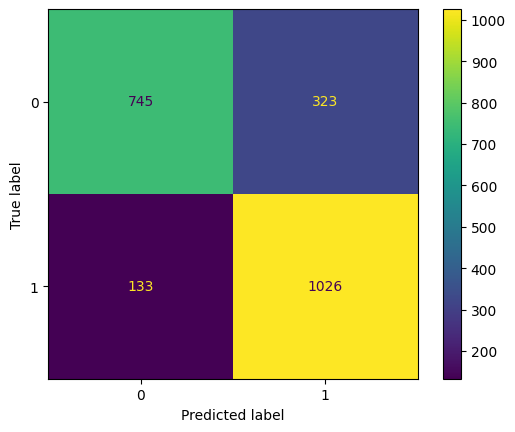

In [185]:
#save confusion matrix
tn1, fp1, fn1, tp1 = confusion_matrix(y_test, test_nb_cvec_preds).ravel()

#show confusion matrix values
cm_nb_cvec = confusion_matrix(y_test,test_nb_cvec_preds)
disp =ConfusionMatrixDisplay(confusion_matrix=cm_nb_cvec, 
                             display_labels=gs.best_estimator_.classes_)
disp.plot();


In [118]:
#sensitivity score
sen_nb_cvec = tp1 / (tp1+fn1)
print(f"Sensitivity value: {sen_nb_cvec : 0.2%}")

Sensitivity value:  88.52%


2. Settings to be used for this modelling 
    - Model : Naive Bayes
    - Vectorizer : TF-IDF

In [119]:
#setup pipeline

pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [120]:
#set parameter 

pipe_tvec_params = {
    'tvec__max_features' : [2_000, 3_000, 4_000, 5_000],
    'tvec__stop_words' : [None, 'english'],
    'tvec__ngram_range' : [(1,1),(1,2),(2,2)]
}

In [121]:
gs_tvec = GridSearchCV(pipe_tvec,
                       param_grid=pipe_tvec_params,
                       cv=5)

In [122]:
gs_tvec.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'tvec__stop_words': [None, 'english']})

In [123]:
#print best score
gs_tvec.best_score_

0.7821194689273139

`Accuracy` and `Recall` Score

In [190]:
#get prediction
train_nb_tvec_preds = gs_tvec.predict(X_train)
test_nb_tvec_preds = gs_tvec.predict(X_test)


#accuracy score
print(f"Train accuracy score: {accuracy_score(y_train, train_nb_tvec_preds)}")
print(f"Test accuracy score: {accuracy_score(y_test, test_nb_tvec_preds)}")

print(f"Train recall score: {recall_score(y_train, train_nb_tvec_preds)}")
print(f"Test recall score: {recall_score(y_test, test_nb_tvec_preds)}")



Train accuracy score: 0.8301886792452831
Test accuracy score: 0.7880556802873822
Train recall score: 0.9360967184801382
Test recall score: 0.910267471958585


Create Confusion Matrix

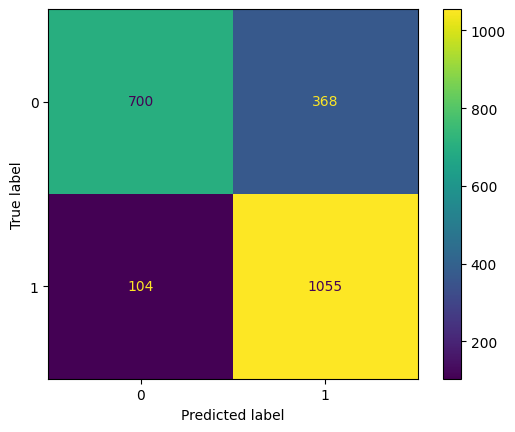

In [191]:
#save confusion matrix
tn2, fp2, fn2, tp2 = confusion_matrix(y_test,test_nb_tvec_preds).ravel()

#show confusion matrix values
cm_nb_tvec = confusion_matrix(y_test,test_nb_tvec_preds)
disp =ConfusionMatrixDisplay(confusion_matrix=cm_nb_tvec, 
                             display_labels=gs_tvec.best_estimator_.classes_)
disp.plot();

#### **3.2 Logistic Regression**

---

1. Settings to be used for this modelling 
    - Model : Logistic Regression
    - Vectorizer : Countervectorizer

In [131]:
#instantiate pipeline 
pipe_logreg_cvec = Pipeline([
    ('cvec', CountVectorizer()),
    ('logreg', LogisticRegression())
])

In [132]:
pipe_logreg_cvec_params = {
    'cvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'cvec__min_df' : [1,2],
    'cvec__max_df' : [0.9,0.95],
    'cvec__ngram_range' : [(1,1),(1,2),(2,2)],
    'logreg__C' : [0.1,1,10],
    'logreg__penalty' : ['l1','l2']
}

In [133]:
gs_logreg_cvec  = GridSearchCV(pipe_logreg_cvec,
                               param_grid= pipe_logreg_cvec_params,
                               cv = 5)

In [134]:
gs_logreg_cvec.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('logreg', LogisticRegression())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [2000, 3000, 4000, 5000],
                         'cvec__min_df': [1, 2],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'logreg__C': [0.1, 1, 10],
                         'logreg__penalty': ['l1', 'l2']})

In [135]:
#check best score 
gs_logreg_cvec.best_score_

0.8295926125277535

`Accuracy` and `Recall` Score

In [192]:
#get prediction
train_logreg_cvec_preds = gs_logreg_cvec.predict(X_train)
test_logreg_cvec_preds = gs_logreg_cvec.predict(X_test)

#accuracy score
print(f"Train accuracy score: {accuracy_score(y_train, train_logreg_cvec_preds)}")
print(f"Test accuracy score: {accuracy_score(y_test, test_logreg_cvec_preds)}")

print(f"Train recall score: {recall_score(y_train, train_logreg_cvec_preds)}")
print(f"Test recall score: {recall_score(y_test, test_logreg_cvec_preds)}")



Train accuracy score: 0.9191374663072777
Test accuracy score: 0.8266726537943422
Train recall score: 0.8753598157743235
Test recall score: 0.7834339948231234


Create Confusion Matrix 

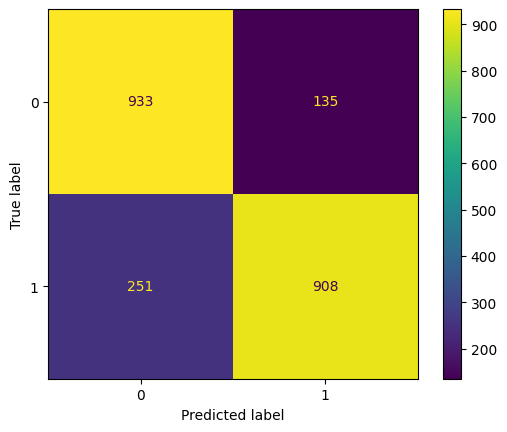

In [193]:
#save confusion matrix
tn3, fp3, fn3, tp3 = confusion_matrix(y_test, test_logreg_cvec_preds).ravel()

#show confusion matrix values
cm_logreg_cvec = confusion_matrix(y_test, test_logreg_cvec_preds)
disp =ConfusionMatrixDisplay(confusion_matrix=cm_logreg_cvec, 
                             display_labels=gs_logreg_cvec.best_estimator_.classes_)
disp.plot();

2. Settings to be used for this modelling 
    - Model : Logistic Regression
    - Vectorizer : TF-IDF

In [139]:
#setup pipeline
pipe_logreg_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logreg', LogisticRegression())
])

In [140]:
#set pipeline parameters
pipe_logreg_tvec_params = {  
    'tvec__max_features' : [2_000, 3_000, 4_000, 5_000],
    'tvec__stop_words' : [None, 'english'],
    'tvec__ngram_range' : [(1,1),(1,2),(2,2)],
    'logreg__C' : [0.1,1,10],
    'logreg__penalty' : ['l1','l2']
}

In [141]:
gs_logreg_tvec = GridSearchCV(pipe_logreg_tvec,
                              param_grid=pipe_logreg_tvec_params,
                              cv=5)

In [142]:
gs_logreg_tvec.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('logreg', LogisticRegression())]),
             param_grid={'logreg__C': [0.1, 1, 10],
                         'logreg__penalty': ['l1', 'l2'],
                         'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'tvec__stop_words': [None, 'english']})

In [143]:
#check best score 
gs_logreg_tvec.best_score_

0.8345326201529526

`Accuracy` and `Recall` Score

In [194]:
#get prediction
train_logreg_tvec_preds = gs_logreg_tvec.predict(X_train)
test_logreg_tvec_preds = gs_logreg_tvec.predict(X_test)

#accuracy score
print(f"Train accuracy score: {accuracy_score(y_train, train_logreg_tvec_preds)}")
print(f"Test accuracy score: {accuracy_score(y_test, test_logreg_tvec_preds)}")

print(f"Train recall score: {recall_score(y_train, train_logreg_tvec_preds)}")
print(f"Test recall score: {recall_score(y_test, test_logreg_tvec_preds)}")



Train accuracy score: 0.89937106918239
Test accuracy score: 0.8343062415806017
Train recall score: 0.8796776050662061
Test recall score: 0.8239861949956859


Create Confusion Matrix

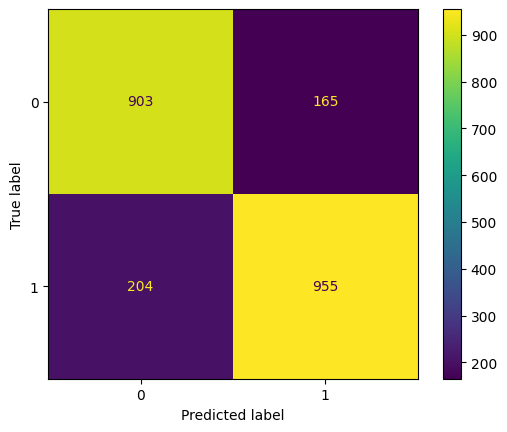

In [195]:
#save confusion matrix
tn4, fp4, fn4, tp4 = confusion_matrix(y_test, test_logreg_tvec_preds).ravel()

#show confusion matrix values
cm_logreg_tvec = confusion_matrix(y_test,test_logreg_tvec_preds)
disp =ConfusionMatrixDisplay(confusion_matrix=cm_logreg_tvec, 
                             display_labels=gs_logreg_tvec.best_estimator_.classes_)
disp.plot();

#### **3.3 K Nearest Neighbor**

---

1. Settings to be used for this modelling 
    - Model : kNN
    - Vectorizer : Countervectorizer

In [147]:
#setup pipeline 

pipe_knn_cvec = Pipeline([
    ('cvec', CountVectorizer()),
    ('knn', KNeighborsClassifier())
])

In [148]:
#setup paratameters for pipeline 
pipe_knn_cvec_params = {
    'cvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'cvec__min_df' : [1,2],
    'cvec__max_df' : [0.9,0.95],
    'cvec__ngram_range' : [(1,1),(1,2),(2,2)],
    'knn__n_neighbors' : [5,10,15],
    'knn__weights' : ['uniform', 'distance'],
    'knn__p' : [1,2]
}

In [149]:
#instantiate Gridsearch
gs_knn_cvec = GridSearchCV(pipe_knn_cvec,
                           param_grid=pipe_knn_cvec_params,
                           cv=5,
                           verbose=1)

In [150]:
gs_knn_cvec.fit(X_train,y_train)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [2000, 3000, 4000, 5000],
                         'cvec__min_df': [1, 2],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'knn__n_neighbors': [5, 10, 15], 'knn__p': [1, 2],
                         'knn__weights': ['uniform', 'distance']},
             verbose=1)

In [151]:
#check best score 
gs_knn_cvec.best_score_

0.7169840095090718

`Accuracy` and `Recall` Score 

In [196]:
#get prediction
train_knn_cvec_preds = gs_knn_cvec.predict(X_train)
test_knn_cvec_preds = gs_knn_cvec.predict(X_test)

#accuracy score
print(f"Train accuracy score: {accuracy_score(y_train, train_knn_cvec_preds)}")
print(f"Test accuracy score: {accuracy_score(y_test, test_knn_cvec_preds)}")

print(f"Train recall score: {recall_score(y_train, train_knn_cvec_preds)}")
print(f"Test recall score: {recall_score(y_test, test_knn_cvec_preds)}")



Train accuracy score: 0.9649595687331537
Test accuracy score: 0.7130669061517737
Train recall score: 0.9427173287276914
Test recall score: 0.5314926660914582


Create Confusion Matrix

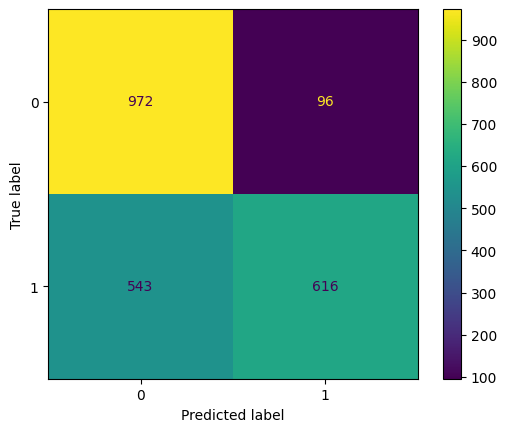

In [197]:
#save confusion matrix
tn5, fp5, fn5, tp5 = confusion_matrix(y_test, test_knn_cvec_preds).ravel()

#show confusion matrix values
cm_knn_cvec = confusion_matrix(y_test,test_knn_cvec_preds)
disp =ConfusionMatrixDisplay(confusion_matrix=cm_knn_cvec, 
                             display_labels=gs_knn_cvec.best_estimator_.classes_)
disp.plot();

2. Settings to be used for this modelling 
    - Model : kNN
    - Vectorizer : TF-IDF

In [155]:
#instantiate pipeline 
pipe_knn_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('knn', KNeighborsClassifier())
])

In [156]:
pipe_knn_tvec_params = {
    'tvec__max_features' : [2_000, 3_000, 4_000, 5_000],
    'tvec__stop_words' : [None, 'english'],
    'tvec__ngram_range' : [(1,1),(1,2),(2,2)],
    'knn__n_neighbors' : [5,10,15],
    'knn__weights' : ['uniform', 'distance'],
    'knn__p' : [1,2]
}

In [157]:
#instantiate Gridsearch
gs_knn_tvec = GridSearchCV(pipe_knn_tvec,
                           param_grid=pipe_knn_tvec_params,
                           cv=5,
                           verbose=1)

In [158]:
gs_knn_tvec.fit(X_train,y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [5, 10, 15], 'knn__p': [1, 2],
                         'knn__weights': ['uniform', 'distance'],
                         'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'tvec__stop_words': [None, 'english']},
             verbose=1)

In [159]:
#check best score 
gs_knn_tvec.best_score_

0.596747516203548

`Accuracy` and `Recall` Score 

In [198]:
#get prediction
train_knn_tvec_preds = gs_knn_tvec.predict(X_train)
test_knn_tvec_preds = gs_knn_tvec.predict(X_test)

#accuracy score
print(f"Train accuracy score: {accuracy_score(y_train, train_knn_tvec_preds)}")
print(f"Test accuracy score: {accuracy_score(y_test, test_knn_tvec_preds)}")

print(f"Train recall score: {recall_score(y_train, train_knn_tvec_preds)}")
print(f"Test recall score: {recall_score(y_test, test_knn_tvec_preds)}")


Train accuracy score: 0.7720874513327344
Test accuracy score: 0.6106870229007634
Train recall score: 0.5639032815198618
Test recall score: 0.28472821397756687


Create Confusion Matrix

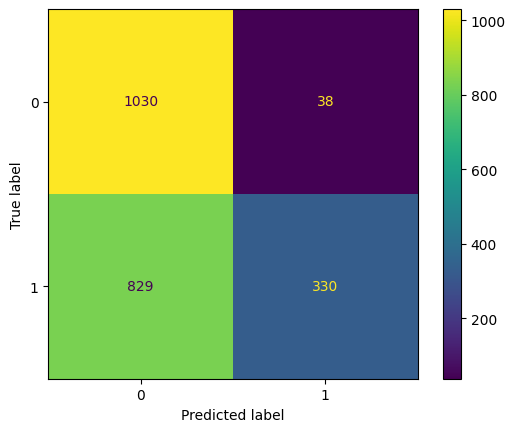

In [199]:
#save confusion matrix
tn6, fp6, fn6, tp6 = confusion_matrix(y_test, test_knn_tvec_preds).ravel()

#show confusion matrix values
cm_knn_tvec = confusion_matrix(y_test,test_knn_tvec_preds)
disp =ConfusionMatrixDisplay(confusion_matrix=cm_knn_tvec, 
                             display_labels=gs_knn_tvec.best_estimator_.classes_)
disp.plot();

**Summary of hypertuned models `accuracy` score**

||Naive Bayes|Logistics Regression|k Nearest Neighbor|
|---|---|---|---|
|CounterVectorizer|train = 0.829 <br> test = 0.795|train = 0.919 <br> test = 0.827|train = 0.965 <br> test = 0.713|
|TF-IDF|train = 0.830 <br> test = 0.789|train = 0.899 <br> test = 0.834|train = 0.772 <br> test = 0.611|

**Summary of hypertuned models `recall` score**

||Naive Bayes|Logistics Regression|k Nearest Neighbor|
|---|---|---|---|
|CounterVectorizer|train = 0.896 <br> test = 0.885|train = 0.875 <br> test = 0.783|train = 0.943 <br> test = 0.531|
|TF-IDF|train = 0.936 <br> test = 0.910|train = 0.880 <br> test = 0.824|train = 0.563 <br> test = 0.285|

After hypertuning, the Naive Bayes model with TF-IDF appears to perform the best among the six models evaluated. It shows the smallest difference between train and test values, indicating a good fit. Additionally, this model has the highest `recall` score, making it the final model chosen for use.





### **Conclusion**
---

- A model is developed to identify youth at risk of depression by detecting words that indicate depressive tendencies.
- Depression is a serious and prevalent issue in our society that needs to be addressed at a young age.
- Instead of waiting for youths to seek help, our model allows for proactive identification of those at risk of depression by analyzing their language.

### **Recommendations**
---

- Social media companies can apply our predictive model to analyze posts made by youths online.
- Youths identified by our model as being at risk of depression can then be referred to support organizations, such as Care Corner or Tinkle Friend.


### **Future Works**
---

- Collaborate with the Ministry of Education (MOE) to apply our model to their database of students' termly check-in surveys, enabling schools to take proactive measures to support at-risk students.
- Integrate our model into social media platforms to function similarly to autocorrect, detecting words indicative of depression.
- Explore partnerships with search engines to make predictions based on users' search queries.
- **Model future improvements**:
  - The model may not detect words in short form or slang, which are unique to different countries. Including these slang words in our training dataset could improve its performance.
  - The model may falsely detect sarcastic posts as indicators of depression.


### **Prediction Simulation**
---

In this part of the notebook, we will use the selected model to predict whether a Reddit post falls under the category of having depression or not. The sample posts are taken from subreddits other than `r/depression` and `r/happy`.

1. Preparation 


Copy custom stopwords identified on notebook part 3

In [205]:
custom_stopwords = ['ur','us','may','many', 'nd', 'either', 'might', 'unless',
                    'even', 'https', 'en', 'org', 'name', 'two' , 'im', 'ive',
                    'yet', 'two', 'op', 'ops', 'usually', 'pm', 'pms', 'else',
                    'often', 'ones', 'would', 'alt', 'others', 'except', 'many',
                    'much','also', 'always', 'www', 'com', 'since', 'everyone',
                    'ysk', 'yalls', 'cuz','coulda', 'really', 'day', 'ei',
                    'ol', 'nada', 'year','years', 'oc', 'month', 'hours','week',
                    'day', 'awwww', 'btw'
                    ]

Create function to filter out stopwrods

In [206]:
def custom_stopword_filter(data, stopword):
    data = pd.Series(data)
    # print(data)
    filtered_data = []
    for word in data:
        if word not in stopword:
            filtered_data.append(word)
        else:
            continue
        # print(data[i])
        # filtered_data.append([word for word in data[i] if word not in stopword])

    # print(filtered_data) 
    return filtered_data

Create function to predict the outcome of a text inserted into the function

Expected output:
1. Have depression
2. No depression

In [208]:
def predictor(text):
    #instantiate tokenizer
    tokenizer = RegexpTokenizer(r'[a-z]\w+')
    token = tokenizer.tokenize(text)
    #filter stopword english
    filtered_word = custom_stopword_filter(token, stopword = stopwords.words('english'))
    #filtered custom word
    filtered_word = custom_stopword_filter(filtered_word , custom_stopwords)
   
    preds = gs_tvec.predict([' '.join(filtered_word)])

    if preds == 1:
        print("You are at risk of depression")
    else:
        print("No depression")

    
    

2. Prediction



Prediction 2.1: 

`r/mentalhealh` is a forum to discuss, vent, support and share information about mental health, illness and wellness

Sample Post: [Source r/mentalhealth](https://www.reddit.com/r/mentalhealth/comments/1bnib6u/my_ex_said_i_sexually_assaulted_her/)

*So the incident happened a few months ago, me and my girlfriend at the time were getting intimate and she asked me if she could suck it so I said well you could sit on it and she obliged. During the sex (she was ontop) she said she was tired to I asked her to keep going and she did, eventually she got off and looked upset so I asked her about what was up and she said I didn’t listen to her and what not and I felt a great deal of guilt. Anyway we spoke about it more and I asked her if I held her down or did I rape her or did I sexually assault her and she said I didn’t to all of that. So we split up earlier this month and she came up to me today saying how I did this that and the other and that incident came up, she said I held my hands on her hips which I didn’t and she said I sexually assaulted her, she also said she wants nothing to do with me. Closer to the time of the incident she spoke to one of our mutuals about it who at first was angry but then when I spoke to them about it and said what happened in more detail about the incident they said I shouldn’t feel guilty but right now I feel so shit about the whole thing. She’s adding things that didn’t happen to the story yes but something still happened and I just don’t know what to do*

In [209]:
text_sample = "So the incident happened a few months ago, me and my girlfriend at the time were getting intimate and she asked me if she could suck it so I said well you could sit on it and she obliged. During the sex (she was ontop) she said she was tired to I asked her to keep going and she did, eventually she got off and looked upset so I asked her about what was up and she said I didn’t listen to her and what not and I felt a great deal of guilt. Anyway we spoke about it more and I asked her if I held her down or did I rape her or did I sexually assault her and she said I didn’t to all of that. So we split up earlier this month and she came up to me today saying how I did this that and the other and that incident came up, she said I held my hands on her hips which I didn’t and she said I sexually assaulted her, she also said she wants nothing to do with me. Closer to the time of the incident she spoke to one of our mutuals about it who at first was angry but then when I spoke to them about it and said what happened in more detail about the incident they said I shouldn’t feel guilty but right now I feel so shit about the whole thing. She’s adding things that didn’t happen to the story yes but something still happened and I just don’t know what to do"

In [210]:
predictor(text_sample)

You are at risk of depression


Prediction 2.2

r/positivity is a subreddit forum to share positive and uplifting stories

Sample Post: [Source r/positivity](https://www.reddit.com/r/Positivity/comments/1bnqbbx/life_is_so_cool/)

*just sat down to have a snack and got ran over by a feeling of gratefulness and contentment when i looked down at the cup of coffee and grilled cheese i made life is so cool dude*

In [211]:
text_sample_2 = "just sat down to have a snack and got ran over by a feeling of gratefulness and contentment when i looked down at the cup of coffee and grilled cheese i made life is so cool dude"

In [212]:
predictor(text_sample_2)

No depression
